In [1]:
"""Import Statements"""
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_material(materials, name):
    """
    searches materials object for a matching name and returns it
    """
    for material in materials:
        if material.name == name:
            return material


def fuel_assembly(propellent, clad, fuel):
    # build a single element
    # Measurements from Schnitzler et al. 2012
    propellant_channel_diameter = 0.2565
    propellant_channel_inner_cladding_thickness = 0.01
    propellant_channel_pitch = 0.4089
    assembly_cladding_thickness = 0.005
    flat_to_flat = 1.905
    flat_to_flat_fuel = flat_to_flat - assembly_cladding_thickness
    assembly_edge_length = 0.5*flat_to_flat/np.cos(np.deg2rad(30))
    fuel_edge_length = 0.5*flat_to_flat_fuel/np.cos(np.deg2rad(30))

    # OpenMC Geometry
    borehole = openmc.ZCylinder(r=propellant_channel_diameter/2)
    borehole_inner_cladding = openmc.ZCylinder(r=propellant_channel_diameter/2
                                               - propellant_channel_inner_cladding_thickness)
    fuel_assembly = openmc.model.HexagonalPrism(
        orientation='x', edge_length=fuel_edge_length)
    fuel_assembly_cladding = openmc.model.HexagonalPrism(
        orientation='x', edge_length=assembly_edge_length)

    # OpenMC Cells and Universes
    propellant_channel_interior = openmc.Cell(
        region=-borehole_inner_cladding, fill=propellent)
    propellant_channel_cladding = openmc.Cell(
        region=-borehole & +borehole_inner_cladding, fill=clad)
    propellant_channel_outer_fuel = openmc.Cell(region=+borehole, fill=fuel)
    propellant_channel = openmc.Universe(cells=(propellant_channel_interior, propellant_channel_cladding,
                                                propellant_channel_outer_fuel))
    fuel_assembly_cell = openmc.Cell(region=-fuel_assembly, fill=fuel)
    fuel_assembly_cladding_cell = openmc.Cell(
        region=+fuel_assembly & -fuel_assembly_cladding, fill=clad)

    outer_lattice_universe = openmc.Universe(cells=[fuel_assembly_cell])

    # OpenMC Fuel Lattice
    fuel_lattice = openmc.HexLattice()
    fuel_lattice.orientation = "x"
    fuel_lattice.outer = outer_lattice_universe
    fuel_lattice.pitch = (propellant_channel_pitch,)
    fuel_lattice.universes = [[propellant_channel] *
                              12, [propellant_channel]*6, [propellant_channel]]
    fuel_lattice.center = (0.0, 0.0)

    # Full Fuel Asembly
    fuel_assembly_lattice_cell = openmc.Cell(
        region=-fuel_assembly, fill=fuel_lattice)
    fuel_assembly_universe = openmc.Universe(cells=[fuel_assembly_cladding_cell,
                                                    fuel_assembly_lattice_cell])

    return fuel_assembly_universe


def tie_tube(hydrogen_inner, hydrogen_outer, inconel, ZrH, ZrC, ZrC_insulator, graphite):
    
    #THIS IS A GUESS BASED ON THE FUEL ELEMENT
    assembly_cladding_thickness = 0.005
    
    inner_hydrogen_outer_radius = 0.20955
    inner_tie_tube_outer_radius = 0.26035
    first_gap_outer_radius = 0.26670
    moderator_outer_radius = 0.58420
    second_gap_outer_radius = 0.67818
    outer_tie_tube_outer_radius = 0.69850
    third_gap_outer_radius = 0.70485
    insulator_outer_radius = 0.80645
    fourth_gap_outer_radius = 0.81280
    flat_to_flat = 1.905
    flat_to_flat_inner = flat_to_flat-2*assembly_cladding_thickness
    assembly_edge_length = 0.5*flat_to_flat/np.cos(np.deg2rad(30))
    inner_edge_length = 0.5*flat_to_flat_inner/np.cos(np.deg2rad(30))

    # OpenMC Geometry
    inner_hydrogen = openmc.ZCylinder(r=inner_hydrogen_outer_radius)
    inner_tie_tube = openmc.ZCylinder(r=inner_tie_tube_outer_radius)
    first_gap = openmc.ZCylinder(r=first_gap_outer_radius)
    moderator_tube = openmc.ZCylinder(r=moderator_outer_radius)
    second_gap = openmc.ZCylinder(r=second_gap_outer_radius)
    outer_tie_tube = openmc.ZCylinder(r=outer_tie_tube_outer_radius)
    third_gap = openmc.ZCylinder(r=third_gap_outer_radius)
    insulator = openmc.ZCylinder(r=insulator_outer_radius)
    fourth_gap = openmc.ZCylinder(r=fourth_gap_outer_radius)
    tie_tube_assembly = openmc.model.HexagonalPrism(orientation='x',
                                                    edge_length=inner_edge_length)
    tie_tube_assembly_cladding = openmc.model.HexagonalPrism(orientation='x',
                                                             edge_length=assembly_edge_length)

    # OpenMC Cells and Universes
    inner_hydrogen_cell = openmc.Cell(region=-inner_hydrogen, fill=hydrogen_inner)
    inner_tie_tube_cell = openmc.Cell(
        region=+inner_hydrogen & - inner_tie_tube, fill=inconel)
    first_gap_cell = openmc.Cell(region=+inner_tie_tube & -first_gap, fill=hydrogen_outer)
    moderator_tube_cell = openmc.Cell(region=+first_gap & -moderator_tube,fill=ZrH)
    outer_hydrogen_cell = openmc.Cell(region=+moderator_tube & -second_gap, fill=hydrogen_outer)
    outer_tie_tube_cell = openmc.Cell(region=+second_gap & -outer_tie_tube, fill=inconel)
    third_gap_cell = openmc.Cell(region=+outer_tie_tube & -third_gap, fill=hydrogen_outer)
    insulator_cell = openmc.Cell(region=+outer_tie_tube & -insulator,fill = ZrC_insulator)
    fourth_gap_cell = openmc.Cell(region=+insulator & -fourth_gap, fill=hydrogen_outer)
    tie_tube_assembly_cell = openmc.Cell(region=-tie_tube_assembly & +fourth_gap, fill=graphite)
    tie_tube_assembly_cladding_cell = openmc.Cell(
        region=+tie_tube_assembly & -tie_tube_assembly_cladding, fill=ZrC)

    # Full Tie Tube Assembly
    tie_tube_assembly_universe = openmc.Universe(cells=[inner_hydrogen_cell, inner_tie_tube_cell, first_gap_cell,
                                                        moderator_tube_cell, outer_hydrogen_cell, outer_tie_tube_cell,
                                                        third_gap_cell, insulator_cell, fourth_gap_cell,
                                                        tie_tube_assembly_cell, tie_tube_assembly_cladding_cell])
    
    return tie_tube_assembly_universe

def reflector(poison_material, reflector_material, bolt_material,
                           reflector_id = 67.31,reflector_thickness = 14.7,
                           drum_radius = 12.7/2, poison_thickness = 0.65,
                           poison_angle_span = 120, 
                           sector_bolt_diameter = 1.057, 
                           drum_bolt_diameter = 0.478,
                           clocking = 0):

    def get_poison_planes(clocking_angle, poison_angle):
        #return 2 planes +/- poison_angle/2 from the clocking angle

        angle1 = np.deg2rad(clocking_angle-poison_angle/2)
        angle2 = np.deg2rad(clocking_angle+poison_angle/2)

        plane1 = openmc.Plane.from_points((0,0,0),(0,0,1),(np.cos(angle1),
                                                           np.sin(angle1),
                                                           0))
        
        plane2 = openmc.Plane.from_points((0,0,0),(0,0,1),(np.cos(angle2),
                                                           np.sin(angle2),
                                                           0))

        return plane1, plane2
    
    def get_12_regions(region):
        
        # Turn 1 drum/poison region into 12
        full_region = region

        angles = np.linspace(30, 360, 11)

        for angle in angles:
            full_region = (full_region | 
                                region.rotate((0,0,-angle)))
    

        return full_region

    reflector_od = reflector_id + 2*reflector_thickness
    drum_od = openmc.ZCylinder(r=drum_radius)
    poison_id = openmc.ZCylinder(r=drum_od.r-poison_thickness)
    poison_plane_1, poison_plane_2 = get_poison_planes(clocking,
                                                       poison_angle_span)
    drum_tie_bolt = openmc.ZCylinder(r=drum_bolt_diameter/2)
    sector_tie_bolt_cyl = openmc.ZCylinder(r=sector_bolt_diameter/2)

    sector_bolt1_region = -sector_tie_bolt_cyl
    sector_bolt2_region = -sector_tie_bolt_cyl

    sector_bolt1_region = sector_bolt1_region.translate((-reflector_id/2-2/3*reflector_thickness,0,0))
    sector_bolt2_region = sector_bolt2_region.translate((-reflector_id/2-1/3*reflector_thickness,0,0))

    sector_bolt_region = sector_bolt1_region | sector_bolt2_region

    sector_bolt_region = sector_bolt_region.rotate((0,0,15))
    poison_region = +poison_id & -drum_od & +poison_plane_1 & -poison_plane_2
    drum_region = -drum_od & +drum_tie_bolt & ~poison_region
    drum_bolt_region = -drum_tie_bolt

    poison_region = poison_region.translate((-(reflector_id+reflector_od)/4,
                                             0,
                                             0))
    drum_region = drum_region.translate((-(reflector_id+reflector_od)/4,
                                         0,
                                         0))
    
    drum_bolt_region = drum_bolt_region.translate((-(reflector_id+reflector_od)/4,
                                         0,
                                         0))

    drum_region = get_12_regions(drum_region)
    poison_region = get_12_regions(poison_region)
    sector_bolt_region = get_12_regions(sector_bolt_region)
    drum_bolt_region = get_12_regions(drum_bolt_region)

    poison_cell = openmc.Cell(region=poison_region, fill=poison_material)
    drum_cell = openmc.Cell(region=drum_region, fill=reflector_material)
    sector_bolt_cell = openmc.Cell(region=sector_bolt_region, fill=bolt_material)
    drum_bolt_cell = openmc.Cell(region=drum_bolt_region, fill = bolt_material)

    reflector_inner_surface = openmc.ZCylinder(r=reflector_id/2)
    reflector_outer_surface = openmc.ZCylinder(r=reflector_od/2)

    reflector_region = (-reflector_outer_surface & 
                        +reflector_inner_surface & 
                        ~drum_region & ~poison_region)

    reflector_cell = openmc.Cell(region=reflector_region, fill=reflector_material)

    reflector_universe = openmc.Universe(cells=[reflector_cell, 
                                                drum_cell, 
                                                poison_cell,
                                                sector_bolt_cell,
                                                drum_bolt_cell])
    
    return reflector_universe

def beryllium_assembly(Be, ZrC):
    
    # Measurements from Schnitzler et al. 2012
    assembly_cladding_thickness = 0.005
    flat_to_flat = 1.905
    flat_to_flat_inner = flat_to_flat-2*assembly_cladding_thickness
    assembly_edge_length = 0.5*flat_to_flat/np.cos(np.deg2rad(30))
    inner_edge_length = 0.5*flat_to_flat_inner/np.cos(np.deg2rad(30))
    
    # OpenMC Geometry:
    beryllium_assembly = openmc.model.HexagonalPrism(orientation='x',
                                                    edge_length=inner_edge_length)
    beryllium_assembly_cladding = openmc.model.HexagonalPrism(orientation='x',
                                                             edge_length=assembly_edge_length)
    
    
    # Cells and Universes:
    beryllium_assembly_cell = openmc.Cell(region=-beryllium_assembly, fill=Be)
    beryllium_assembly_cladding_cell = openmc.Cell(
        region=+beryllium_assembly & -beryllium_assembly_cladding, fill=ZrC)
    
    beryllium_assembly_universe = openmc.Universe(cells=[beryllium_assembly_cell, beryllium_assembly_cladding_cell])
    
    return beryllium_assembly_universe

def core_lattice_SNRE(tie_tube_universe, fuel_assembly_universe, beryllium_universe):
    
    # Measurements from Schnitzler et al. 2012
    assembly_pitch = 1.905
    
    
    # Makes things easier to type:
    TT = tie_tube_universe
    FA = fuel_assembly_universe
    BE = beryllium_universe
    
    core_lattice = openmc.HexLattice()
    core_lattice.orientation = "y"
    core_lattice.pitch = (assembly_pitch,)
    core_lattice.universes = [[BE, BE, BE, BE, BE, BE, BE, BE, BE, BE, BE, BE, BE, BE, BE, BE, BE, BE]*6,
                              [BE, BE, BE, BE, BE, BE, BE, FA, FA, FA, FA, BE, BE, BE, BE, BE, BE]*6,
                              [BE, BE, BE, FA, FA, FA, FA, FA, TT, FA, FA, FA, FA, FA, BE, BE]*6,
                              [BE, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA]*6,
                              [FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT]*6,
                              [FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA]*6,
                              [TT, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA]*6,
                              [FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT]*6,
                              [FA, FA, TT, FA, FA, TT, FA, FA, TT, FA]*6,
                              [TT, FA, FA, TT, FA, FA, TT, FA, FA]*6,
                              [FA, TT, FA, FA, TT, FA, FA, TT]*6,
                              [FA, FA, TT, FA, FA, TT, FA]*6,
                              [TT, FA, FA, TT, FA, FA]*6,
                              [FA, TT, FA, FA, TT]*6,
                              [FA, FA, TT, FA]*6,
                              [TT, FA, FA]*6,
                              [FA, TT]*6,
                              [FA]*6,
                              [TT]]
    core_lattice.center=(0.0,0.0)
    core_lattice_cell = openmc.Cell(fill=core_lattice)
    core_lattice_universe = openmc.Universe(cells=[core_lattice_cell])
    
    return core_lattice_universe

def inner_reflector(Core, Gap, SS, Be_Barrel):
    
    #Measurements from Schnitzler et al. 2007
    inner_gap_inner_radius = 29.5275
    inner_gap_outer_radius = 29.8450
    stainless_steel_outer_radius = 30.1625
    middle_gap_outer_radius = 30.48
    be_barrel_outer_radius = 33.3375
    outer_gap_outer_radius = 33.6550
    
    # OpenMC Geometry:
    inner_gap_inner = openmc.ZCylinder(r=inner_gap_inner_radius)
    inner_gap_outer = openmc.ZCylinder(r=inner_gap_outer_radius)
    wrapper = openmc.ZCylinder(r=stainless_steel_outer_radius)
    middle_gap = openmc.ZCylinder(r=middle_gap_outer_radius)
    be_barrel = openmc.ZCylinder(r=be_barrel_outer_radius)
    outer_gap = openmc.ZCylinder(r=outer_gap_outer_radius)
    
    # OpenMC Cells and Universes:
    core_cell = openmc.Cell(region=-inner_gap_inner, fill=Core)
    inner_gap_cell = openmc.Cell(region = -inner_gap_outer & + inner_gap_inner, fill=Gap)
    stainless_steel_wrapper_cell = openmc.Cell (region = +inner_gap_outer & -wrapper, fill=SS)
    middle_gap_cell = openmc.Cell(region = +wrapper & -middle_gap, fill=Gap)
    be_barrel_cell = openmc.Cell(region = +middle_gap & -be_barrel, fill=Be_Barrel)
    outer_gap_cell = openmc.Cell(region = +be_barrel & -outer_gap, fill=Gap)
    
    reflector_universe = openmc.Universe(cells=[core_cell, inner_gap_cell,
                                                stainless_steel_wrapper_cell,
                                                middle_gap_cell, be_barrel_cell,
                                                outer_gap_cell])
    
    return reflector_universe

def full_core(inner_reflector_universe, poison_mat, reflector_mat, bolt_mat, core_height, drum_clocking):
    inner_reflector_outer_radius = 33.6550
    reflector_outer_radius = inner_reflector_outer_radius + 14.7
    
    
    # OpenMC Geometry:
    inner_reflector_outer_boundary = openmc.ZCylinder(r=inner_reflector_outer_radius)
    outer_reflector_outer_boundary = openmc.ZCylinder(r=reflector_outer_radius)

    core_bottom = openmc.ZPlane(z0=-core_height/2)
    core_top = openmc.ZPlane(z0=core_height/2)

    outer_reflector_outer_boundary.boundary_type = 'vacuum'
    core_bottom.boundary_type = 'vacuum'
    core_top.boundary_type = 'vacuum'
    
    # OpenMC Cells and Universes:
    reflector_universe = reflector(poison_mat, reflector_mat, bolt_mat, clocking=drum_clocking)
    inner_reflector_cell = openmc.Cell(region = -inner_reflector_outer_boundary
                                       & +core_bottom & -core_top, fill = inner_reflector_universe)
    reflector_cell = openmc.Cell(region= +inner_reflector_outer_boundary & -outer_reflector_outer_boundary
                                 & +core_bottom & -core_top, fill=reflector_universe)
    
    full_core_universe = openmc.Universe(cells=[inner_reflector_cell, reflector_cell])
    
    return full_core_universe

In [3]:
materials = openmc.Materials.from_xml('materials.xml')

hydrogen = get_material(materials, "Hydrogen STP")
ZrC = get_material(materials, "zirconium_carbide")
graphite_fuel = get_material(materials, "graphite_fuel_70U_15C")
ZrH = get_material(materials, 'zirconium_hydride_II')
inconel = get_material(materials, "inconel-718")
ZrC_insulator = get_material(materials,'zirconium_carbide_insulator')
graphite = get_material(materials, 'graphite_carbon')
poison = get_material(materials, 'copper_boron')
beryllium = get_material(materials, 'Beryllium')
SS316L = get_material(materials, "SS316L")



FA = fuel_assembly(hydrogen, ZrC, graphite_fuel)
TT = tie_tube(hydrogen,hydrogen,inconel,ZrH,ZrC,ZrC_insulator,graphite)
BE = beryllium_assembly(beryllium, ZrC)
core = core_lattice_SNRE(TT,FA,BE)
inner_reflector_universe = inner_reflector(core, hydrogen, SS316L, beryllium)

core_height = 120
drum_clocking = 180

full_core_geom = openmc.Geometry(full_core(inner_reflector_universe, poison, beryllium, inconel, core_height, drum_clocking))

In [4]:
model = openmc.model.Model(geometry=full_core_geom, materials=materials)
model.settings.particles = 100_000
model.settings.batches = 50
model.settings.inactive = 10

tally = openmc.Tally()

In [5]:
# Set up our DistribcellFilter


#In the Fuel:
fuel_cells = []
for cell in model.geometry.get_all_material_cells().values():
    if cell.fill.name == "graphite_fuel_70U_15C":
        fuel_cells.append(cell)
    

tally.filters = [openmc.DistribcellFilter(fuel_cells[0]), openmc.DistribcellFilter(fuel_cells[1])]

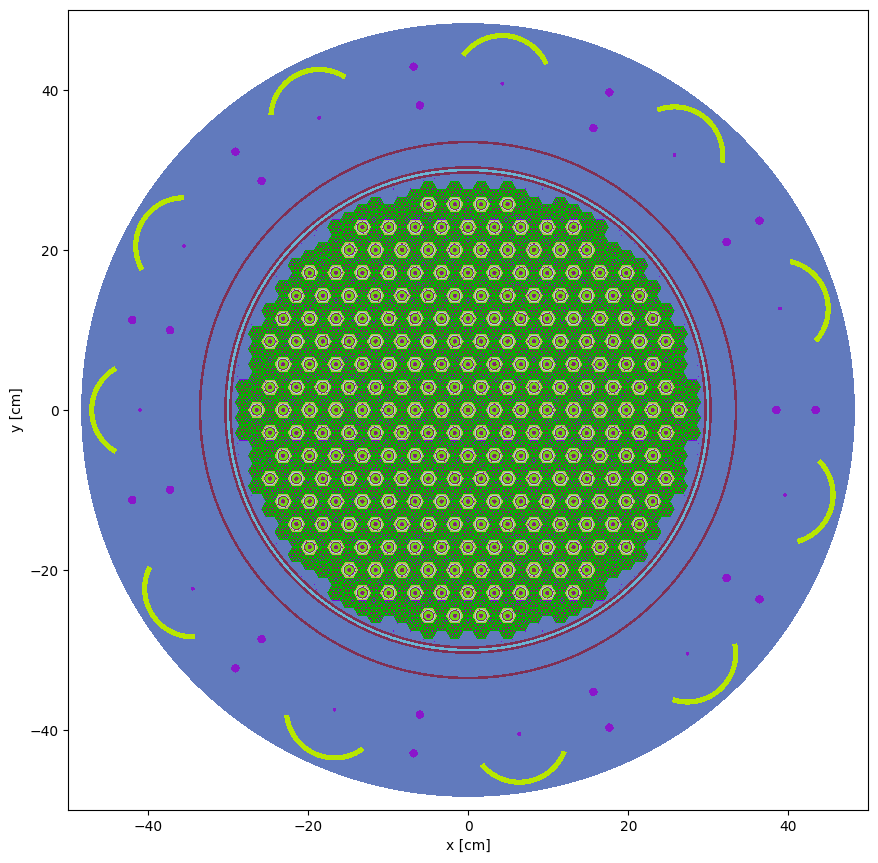

In [6]:
model.geometry.plot(pixels=(800, 800), width=(100, 100), color_by='material')
plt.show()

In [7]:
tally.scores=['heating', 'kappa-fission']
model.settings.photon_transport = True
model.tallies = [tally]

# Grab the correct XS data:
xs_loc = '/filespace/d/dokrueger/NE506/xs_data/endf_b-VII.0/endfb-viii.0-hdf5/cross_sections.xml'
openmc.config['cross_sections'] = xs_loc

In [8]:
# Create Initial Source:

# Measurements from Schnitzler 2007
inner_gap_inner_radius = 29.5275

lower_left = (-inner_gap_inner_radius/2, -inner_gap_inner_radius/2, -core_height/2)
upper_right = (inner_gap_inner_radius/2, inner_gap_inner_radius/2, core_height/2)
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable = True)

# Set the source in settings
model.settings.source = openmc.source.Source(space=uniform_dist)

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [9]:
sp_file = model.run(threads=4)

with openmc.StatePoint(sp_file) as statepoint:
    tally_result = statepoint.tallies[tally.id]

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for C13
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.93668
        2/1    0.93440
        3/1    0.93075
        4/1    0.93254
        5/1    0.93518
        6/1    0.94291
        7/1    0.94139
        8/1    0.94055
        9/1    0.94015
       10/1    0.93291
       11/1    0.93922
       12/1    0.93509    0.93716 +/- 0.00207


KeyboardInterrupt: 